In [171]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow import keras
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

### 특정 폴더 내에 모든 원본 이미지를 읽어들이는 함수 정의

In [104]:
"""특정 원본 이미지 폴더 내에 모든 이미지 파일을 읽어들여서 이미지 픽셀데이터로 변환해서 리턴하는 함수정의"""
def load_images(directory):
    """각 이미지 별 변환 데이터를 저장할 리스트 변수"""
    images = []
    """특정 디렉토리의 모든 파일 읽기"""
    for filename in os.listdir(directory):
        """특정 확장자를 가지는 파일만 읽어들이기"""
        if filename.endswith((".jpg", ".jpeg", ".png")):
            """파일명 추출"""
            img_path= os.path.join(directory, filename)

            #이미지를 3차원 데이터로 변환하기
            img= cv2.imread(img_path)
            
            # 이미지 크기 조정
            img = cv2.resize(img, (200,300))
            #이미지 데이터의 픽셀 크기를 너비 200, 높이 300로 통일 시키기 (정규화)
            # img = cv2.resize(img, (200,300))

            #변환된 이미지 데이터를 리스트 변수에 담기
            images.append(img)

            # if img is not None and not img.size == 0:
            #     # 이미지 크기 조정
            #     # img = cv2.resize(img, (320, 375))
            #     #이미지 데이터의 픽셀 크기를 너비 200, 높이 300로 통일 시키기 (정규화)
            #     img = cv2.resize(img, (200,300))

            #     #변환된 이미지 데이터를 리스트 변수에 담기
            #     images.append(img)
            
            """numpy 배열로 변환하여 리턴"""
            
    return np.array(images)

### 읽어들인 모든 원본 이미지 각각에 대해서 이미지 증식 및 종속변수(라벨) 정의함수

In [105]:
"""
 - images: 원본 전체에 대한 각 이미지 데이터
 - output_directory : 증식한 이미지를 저장할 폴더위치
 - target_filename  : 종속변수 데이터를 저장할 (폴더+파일명)
"""

def create_inages(images, ouput_directory, target_filename) :
    # 종속변수 데이터를 담을 리스트 변수
    target = []

    # 원본 이미지 10개에 대한 라벨링 기준
    # 1은 위험 인자, 0은 안전인자
    target_list = [1,0,1,0,1,1,0,1,1,0]
    # 이미지 증식 객체 생성
    datagen = ImageDataGenerator(  # 이미지 데이터를 0과1 사이의 값으로 정규화하기
        rescale = 1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5,
        zoom_range=[0.8,2.0],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
    )
    ###이미지 증식 시키기###
    # -i : images의 인덱스 번호
    # img: 각 인덱스별 이미지 데이터
    for i , img in enumerate(images):
        print(f"------------------[{i+1}/{len(images)}] 번째 증식 중------------")

        ### 3차원 이미지 데이터를 4차원으로 변환하기
        img = img.reshape((1,) + img.shape)
        # 증식된 이미지를 저장할 파일면 정의
        save_prefix = "train_img_"+str(i)
        # 각 이미지 별로 생성(증식) 할 이미지의 갯수 정의
        create_img_cnt = 20
            # 이미지 증식 및 파일 저장 시키기
        for batch in datagen.flow(img,
                                  save_to_dir=ouput_directory,
                                  save_prefix=save_prefix,
                                  save_format="png"
                                 ):
            # 증식된 이미지 별로 [종속변수]로 사용할 값을 리스트에 담기
            target.append(target_list[i])
            
            # 생성할 이미지 갯수만큼 만들어지면 반복 종료시키기
            create_img_cnt -= 1
            if create_img_cnt ==0:
                break
    ### 종속 변수 리스트를 numpy 배열 타입으로 변환하기
    target = np.array(target)

    # 종속 변수 리스트를 numpy 파일로 저장시키기
    # - target_filename : 저장할 폴더+ 파일명
    # - target : 종속변수 리스트
    np.save(target_filename, target)
"""
너무 많은 증식을 할 경우 원하는 갯수만 큼 증식이 안되는 경우가 있음
- 증식을 만드는 시간과, 시스템 폴어데 저장되는 시간차로 발생
- 많은 양을 만들 경우 조금씩 여러번에 걸쳐서 증식..
"""    

'\n너무 많은 증식을 할 경우 원하는 갯수만 큼 증식이 안되는 경우가 있음\n- 증식을 만드는 시간과, 시스템 폴어데 저장되는 시간차로 발생\n- 많은 양을 만들 경우 조금씩 여러번에 걸쳐서 증식..\n'

### 증식한 이미지 폴더 내에 모든 이미지 파일을 [4차원 데이터]로 변환 및 저장하는 함수

In [106]:
# 증식된 파일이 저장된 폴더 내 모든 파일에 대해서 
# 4차원 데이터로 변환하여 numpy 배열 형태로 저장시키기
# - output_directory : 증식된 파일이 위치한 폴더
# - save_4d_filename : 저장할 파일명
def save_4d_data(output_directory, save_4d_filename):
    # 4차원 데이터를 담을 리스트 변수
    data= []

    # 증식된 모든 파일 읽어들이기
    for filename in os.listdir(output_directory):
        if filename.endswith((".jpg",".jpeg",".png")):
            img_path = os.path.join(output_directory, filename)

            #3차원 데이터로 읽어들이기
            img = cv2.imread(img_path)
            print()
            
            # 픽셀 정규화
            img = cv2.resize(img, (200,300))
            # print(img)

            # 리스트에 담기
            data.append(img)
    data = np.array(data)
    print("최종처리결과 :", data.shape)
    np.save(save_4d_filename, data)

### 함수 호출

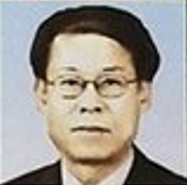

In [94]:
# img = load_img("./data/01_org_img/스크린샷 2024-01-11 141848.png")
img

In [109]:
"""특정 폴더 내에 모든 이미지 파일 로드하여, 이미지 데이터로 변환하는 함수 호출"""
# 폴더 위치 지정
input_directory = "./data/01_org_img/"
# 함수 호출하기
images = load_images(input_directory)
# images.shape

# input_directory = "./data/01_org_img"
# images = load_images(input_directory)
# images.shape


In [110]:

output_directory = "./data/02_train_img"
###종속변수 데이터 파일명
# - numpy 확장자는 보통 .npy를 사용함
target_filename = "./data/03_train_4d_data/target_data.npy"

create_images(images, output_directory,target_filename=target_filename)

--------------[1 / 10] 번째 증식 중---------------
--------------[2 / 10] 번째 증식 중---------------
--------------[3 / 10] 번째 증식 중---------------
--------------[4 / 10] 번째 증식 중---------------
--------------[5 / 10] 번째 증식 중---------------
--------------[6 / 10] 번째 증식 중---------------
--------------[7 / 10] 번째 증식 중---------------
--------------[8 / 10] 번째 증식 중---------------
--------------[9 / 10] 번째 증식 중---------------
--------------[10 / 10] 번째 증식 중---------------


In [145]:
"""증식된 이미지 각각에 대한 이미지 데이터로 변환하여 numpy배열 파일로 저장하기"""
"""numpy로 저장된 독립변수와 종속변수 데이터 확인하기"""
train = np.load(save_4d_filename)
target = np.load(target_filename)
train.shape, target.shape

((200, 300, 200, 3), (200,))

In [146]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [147]:
"""
 - 독립변수 : image_data, 종속변수 : label_data
 - 픽셀 데이터 정규화 (0~1 범위)
 - 훈련 및 테스트 - 8:2로 분리
   사용변수 x_train, x_test, y_train, y_test
"""

'\n - 독립변수 : image_data, 종속변수 : label_data\n - 픽셀 데이터 정규화 (0~1 범위)\n - 훈련 및 테스트 - 8:2로 분리\n   사용변수 x_train, x_test, y_train, y_test\n'

In [148]:
# x_train, x_test, y_train, y_test = train_test_split(image_data, label_data,
#                                                    test_size=0.2,
#                                                    random_state=42)
# print(f"{x_train.shape} / {x_test.shape}")
# print(f"{y_train.shape} / {y_test.shape}")
image_data= np.load("./data/03_train_4d_data/train_4d_data.npy")

label_data= np.load("./data/03_train_4d_data/target_data.npy")
image_data = image_data /255.0
image_data


array([[[[0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         ...,
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451]],

        [[0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         ...,
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451]],

        [[0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         ...,
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451]],

        ...,

        [[0.23921569, 0.26666667, 0.1372549 ],
         [0.23921569, 0.26666667, 0.1372549 ]

In [116]:
image_data= np.load("./data/03_train_4d_data/train_4d_data.npy")

label_data= np.load("./data/03_train_4d_data/target_data.npy")
image_data = image_data /255.0
image_data

array([[[[0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         ...,
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451]],

        [[0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         ...,
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451]],

        [[0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         [0.60392157, 0.79607843, 0.94509804],
         ...,
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451],
         [0.40392157, 0.69411765, 0.88627451]],

        ...,

        [[0.23921569, 0.26666667, 0.1372549 ],
         [0.23921569, 0.26666667, 0.1372549 ]

In [189]:
 X_train, X_test, y_train, y_test= train_test_split(image_data, label_data, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 300, 200, 3), (40, 300, 200, 3), (160,), (40,))

In [190]:
# 모델 정의
model = Sequential()

In [191]:
model.add(keras.layers.Conv2D( kernel_size=3, filters=32, activation="relu", padding="same", strides=1, input_shape=(300, 200, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(keras.layers.Conv2D(kernel_size=3,filters=64,  activation="relu", padding="same", strides=1,  ))
model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [192]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [193]:
history= model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=15)

Epoch 1/15
2/2 [==============================] - 4s 2s/step - loss: 3.4073 - accuracy: 0.5703 - val_loss: 0.7108 - val_accuracy: 0.6562
Epoch 2/15
2/2 [==============================] - 4s 2s/step - loss: 1.6807 - accuracy: 0.5000 - val_loss: 1.0016 - val_accuracy: 0.4062
Epoch 3/15
2/2 [==============================] - 4s 2s/step - loss: 0.8432 - accuracy: 0.5312 - val_loss: 0.6849 - val_accuracy: 0.5938
Epoch 4/15
2/2 [==============================] - 4s 2s/step - loss: 0.6510 - accuracy: 0.6406 - val_loss: 0.6884 - val_accuracy: 0.5938
Epoch 5/15
2/2 [==============================] - 4s 2s/step - loss: 0.6411 - accuracy: 0.6328 - val_loss: 0.6725 - val_accuracy: 0.5938
Epoch 6/15
2/2 [==============================] - 4s 2s/step - loss: 0.6376 - accuracy: 0.6328 - val_loss: 0.6734 - val_accuracy: 0.6250
Epoch 7/15
2/2 [==============================] - 4s 2s/step - loss: 0.6049 - accuracy: 0.7266 - val_loss: 0.6748 - val_accuracy: 0.6250
Epoch 8/15
2/2 [=========================

In [167]:
x_pred = model.predict(X_train[0:2])
x_pred

array([[0.37967438],
       [0.70345056]], dtype=float32)

In [194]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 58ms/step - loss: 0.7813 - accuracy: 0.5250


[0.7812778353691101, 0.5249999761581421]

In [169]:
import os
import cv2
import platform
import winsound
import time

In [213]:
import os

file_path = "./data/04_detection_img/train_0_1554.png"

# 파일 존재 여부 확인
if os.path.exists(file_path):
    print("이미지 파일이 존재합니다.")
else:
    print("이미지 파일이 존재하지 않습니다. 파일 경로를 확인하세요.")

이미지 파일이 존재합니다.


In [216]:
import cv2

# 이미지 읽기 시도
pred_img = cv2.imread(file_path)

# 이미지가 정상적으로 읽힌 경우에만 shape 출력
if pred_img is not None:
    print("이미지 shape:", pred_img.shape)
else:
    print("이미지를 읽는 데 문제가 있습니다. 파일 경로 및 이미지 파일을 확인하세요.")


이미지 shape: (653, 1000, 3)


In [231]:
"""예측할 이미지 불러오기"""
# target_list = [1, 0, 1, 0, 1, 1, 0, 1, 1, 0]
pred_img = cv2.imread("./data/04_detection_img/train_0_1554.png")
# pred_img = cv2.imread("./data/04_dectection_img/1_0.png")

pred_img.shape

"""
predict() 까지 해주세요...
"""
# 이미지 크기 조정
pred_img = cv2.resize(pred_img, (200, 300))
pred_img = pred_img.reshape((1,) + pred_img.shape)
pred_data = pred_img / 255.0
pred_data.shape

y_pred = model.predict(pred_data)
y_pred

if y_pred[0] > 0.5 :
    print(f"인식률[{y_pred[0]}] : 위험 위험")

    ### 윈도우os인 경우
    if platform.system() =="Windows" :
        ### 1000 : 소리 주파수(소리 높낮이 조정값)
        # - 보통 사람의 청각 범위 : 20Hz ~ 20,000Hz 정도..
        ### 500 : 지속시간 (1000은 1초, 500은 0.5초)
        for i in range(5) :
            winsound.Beep(12000, 50)
            time.sleep(0.1)
    
    ### mac인 경우 abs
    elif platform.system() == "Darwin" :
        os.system("osacript -e 'beep'")
else :
    print()

인식률[[0.9013717]] : 위험 위험
